<a href="https://colab.research.google.com/github/Saurabh919yadav/Pneumothorax_detection/blob/master/Pneumothorax_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import numpy as np
import h5py
import os
import matplotlib.pyplot as plt
import uuid
from tqdm import tqdm 

In [66]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
class PneumothoraxDataset:
  def __init__(self):
    
    print("Loading X-ray Dataset !")
    
    train = h5py.File('/content/drive/My Drive/deep_ml/pneumothorax/pneumothorax_train.h5','r')
    test = h5py.File('/content/drive/My Drive/deep_ml/pneumothorax/pneumothorax_test.h5','r')
    
    self.X_train = train['image'][:]
    self.X_test = test['image'][:]
    self.Y_train = train['label'][:]
    self.Y_test = test['label'][:]
    
    self.num_train = self.X_train.shape[0]
    self.num_test = self.X_test.shape[0]
    
    self.batch_pointer = 0
    
  def getTotalNumDataPoints(self):
    return self.num_train + self.num_test
  
  def getTrainDataShape(self):
     return self.X_train.shape
  
  def getTestDataShape(self):
     return self.X_test.shape
  
  def getTrainBatch(self, batch_size):
    inds = np.arrange(self.batch_pointer, self.batch_pointer+batch_size)
    inds = np.mod(inds, self.num_train) #cycle through dataset
    
    batch = (self.X_train[inds], self.Y_train[inds])
    
    self.batch_pointer += batch_size
    
    return batch
  
  def getTestBatch(self, batch_size):
    inds = np.random.choice(self.num_test, size= batch_size)
    return (self.X_test[inds], self.Y_test[inds])
    
    

In [68]:
data  = PneumothoraxDataset()
print("Dataset consists of {} images".format(data.getTotalNumDataPoints()))

Loading X-ray Dataset !
Dataset consists of 9964 images


In [69]:
data.getTrainDataShape()

(8064, 256, 256, 1)

In [70]:
data.getTestDataShape()

(1900, 256, 256, 1)

This X-Ray HAS a pneumothorax


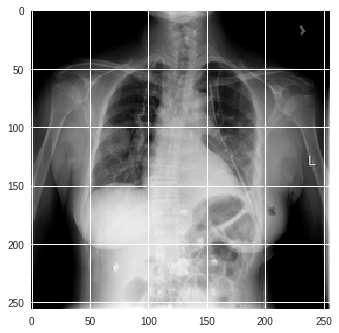

In [71]:
index = 10

image = data.X_train[index]
label = data.Y_train[index]
pred = np.argmax(label)

plt.imshow(image[:,:,0], cmap='gray')
print("This X-Ray "+("HAS" if pred else "DOES NOT have")+ " a pneumothorax")

In [0]:
from keras.models import Sequential
from keras.layers import Dropout, Dense, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adam, Adadelta
from keras.constraints import maxnorm
from keras.utils import np_utils

In [78]:
num_classes=2
epochs = 25
batch_size = 128


#normalize imput from 0-255 to 0.0-1.0
x_train = data.X_train.astype('float32')
x_test = data.X_test.astype('float32')

x_train = x_train.reshape(8064, 256, 256, 1)
x_test = x_test.reshape(1900, 256, 256, 1)

x_train = x_train/255.0
x_test = x_test/255.0
print("X_train shape : "+str(x_train.shape))
print("X_test shape: "+str(x_test.shape))

#convert Y to categorical data
#y_train = np_utils.to_categorical(data.Y_train,num_classes)
#y_test = np_utils.to_categorical(data.Y_test,num_classes)

y_train = data.Y_train
y_test = data.Y_test

print("Y_train shape : "+str(y_train.shape))
print("Y_test shape : "+str(y_test.shape))

X_train shape : (8064, 256, 256, 1)
X_test shape: (1900, 256, 256, 1)
Y_train shape : (8064, 2)
Y_test shape : (1900, 2)


In [0]:
model = Sequential()
model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu',input_shape = (256,256,1), padding = 'same'))
model.add(Dropout(0.2))
model.add(Conv2D(32, kernel_size = (3,3),activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(512, activation = 'relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(1024, activation = 'relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation = 'softmax'))

In [80]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(),
              metrics = ['accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_68 (Conv2D)           (None, 256, 256, 32)      320       
_________________________________________________________________
dropout_79 (Dropout)         (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 256, 256, 32)      9248      
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 128, 128, 64)      18496     
_________________________________________________________________
dropout_80 (Dropout)         (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 128, 128, 64)      36928     
__________

In [82]:
model.fit(x_train, y_train,
          validation_data = (x_test, y_test))

score = model.evaluate(x_test, y_test)
print('test loss',score[0])
print('test accuracy',score[1])

Train on 8064 samples, validate on 1900 samples
Epoch 1/1


ResourceExhaustedError: ignored